In [1]:
%load_ext autoreload
%autoreload 2
import networkx as nx
from sklearn.linear_model import LogisticRegression
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import causalicp as icp
r = np.random  # Random generator
r.seed(1)
from pm4py.algo.discovery.dcr_discover import algorithm as dcr_alg
from pm4py.util.external_functions import *
from data_aware_helper import *

In [2]:
sepsis = pm4py.read_xes('/home/vco/Datasets/Sepsis Cases - Event Log.xes')
sepsis = sepsis.rename({'LacticAcid':'LacticAcidVal','CRP':'CRPVal','Leucocytes':'LeucocytesVal'},axis=1)
events = set(sepsis['concept:name'].unique())
data_attributes = set(sepsis.columns).difference({'org:resource','org:group','lifecycle:transition','concept:name','time:timestamp','case:concept:name'})

parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

In [3]:
attr_events = {}
for attr in data_attributes:
    attr_events[attr] = sepsis[sepsis[attr].notna()]['concept:name'].unique()
events_attr = {}
for k,v in attr_events.items():
    for x in v:
        events_attr.setdefault(x, []).append(k)
domain_knowledge = {'ER Registration': {'DiagnosticBlood':'binomial','SIRSCritHeartRate':'binomial','DiagnosticLiquor':'binomial','DiagnosticUrinaryCulture':'binomial','DiagnosticUrinarySediment':'binomial','Infusion':'binomial','Diagnose':'categorical','Hypotensie':'binomial','DiagnosticIC':'binomial','SIRSCritLeucos':'binomial','Age':'numerical','InfectionSuspected':'binomial','SIRSCritTemperature':'binomial','SIRSCriteria2OrMore':'binomial','SIRSCritTachypnea':'binomial','Oligurie':'binomial','Hypoxie':'binomial','DiagnosticXthorax':'binomial','DiagnosticSputum':'binomial','DiagnosticOther':'binomial','DisfuncOrg':'binomial','DiagnosticECG':'binomial','DiagnosticArtAstrup':'binomial','DiagnosticLacticAcid':'binomial'},
                    'CRP':{'CRPVal':'numerical'},
                    'LacticAcid':{'LacticAcidVal':'numerical'},
                    'Leucocytes':{'LeucocytesVal':'numerical'}
                }

In [4]:
# road_traffic_train, road_traffic_test = temporal_split(road_traffic,.3)
events = set(sepsis['concept:name'].unique())
data_attributes = set(sepsis.columns).difference({'org:resource','lifecycle:transition','concept:name','time:timestamp','case:concept:name'})
event_data_attributes = {}
for event in events:
    event_data_attributes[event] = extract_event_data_attributes(sepsis,event,data_attributes)
events_no_data = set(sepsis['concept:name'].unique()).difference(domain_knowledge.keys())
sepsis_model, log_abs = dcr_alg.apply(sepsis)
events_and_data = set(sepsis['concept:name'].unique())

[i] Mining with basic DisCoveR
[i] Converting to old event log!


/home/vco/Projects/pm4py-dcr/pm4py/utils.py:494: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


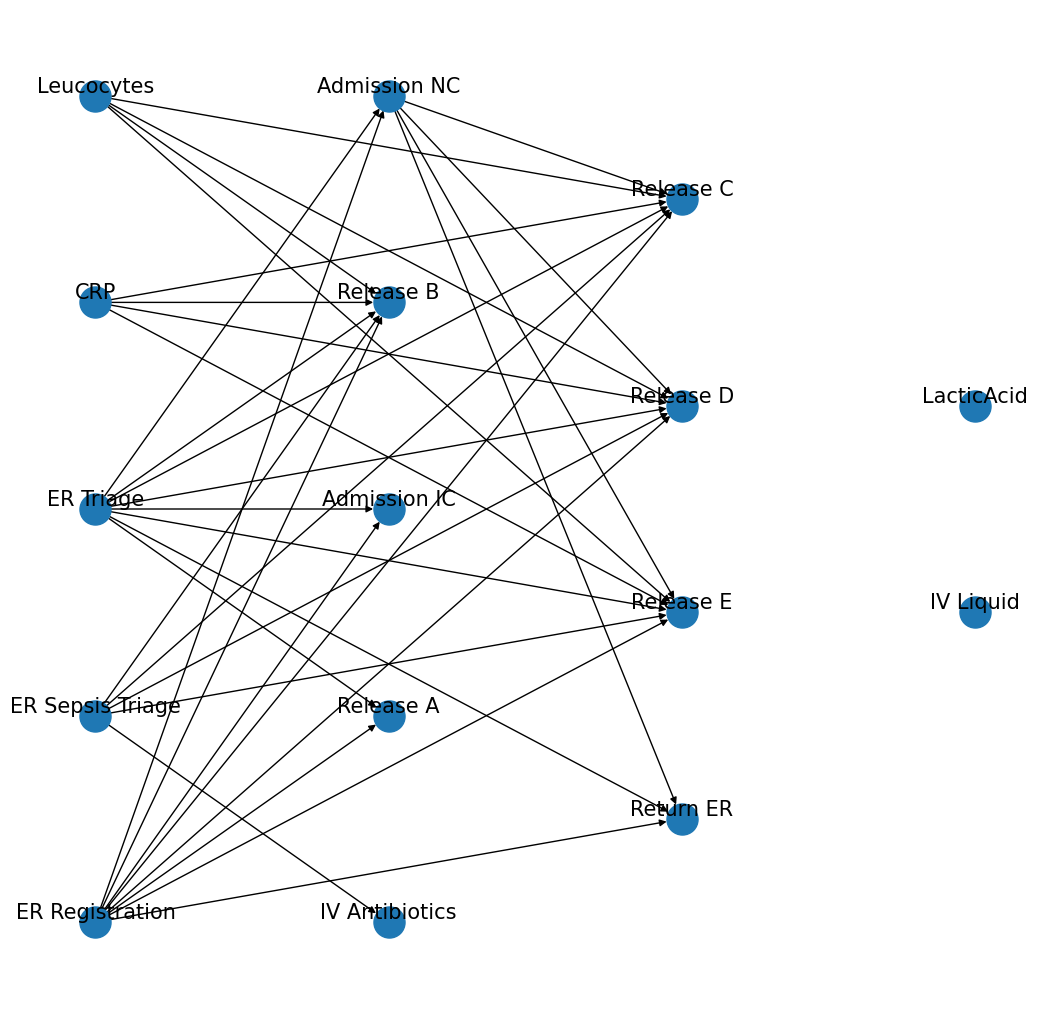

In [5]:
data_filler_adj_matrix = {}
i = len(events)
adj_matrix = np.array([[0 for i in range(len(events_and_data))] for j in range(len(events_and_data))])
idx_dict = {}
for i, e1 in enumerate(events_and_data):
    idx_dict[e1] = i
    for j, e2 in enumerate(events_and_data):
        if e1 in log_abs['precedenceFor'] and e2 in log_abs['precedenceFor'][e1]:
            adj_matrix[j][i] = 1

for e, ds in data_filler_adj_matrix.items():
    for d in ds:
        i = idx_dict[e]
        j = idx_dict[d]
        adj_matrix[j][i] = 1

labels = {i:l for i,l in enumerate(events_and_data)}
show_graph_with_labels(adj_matrix, labels)

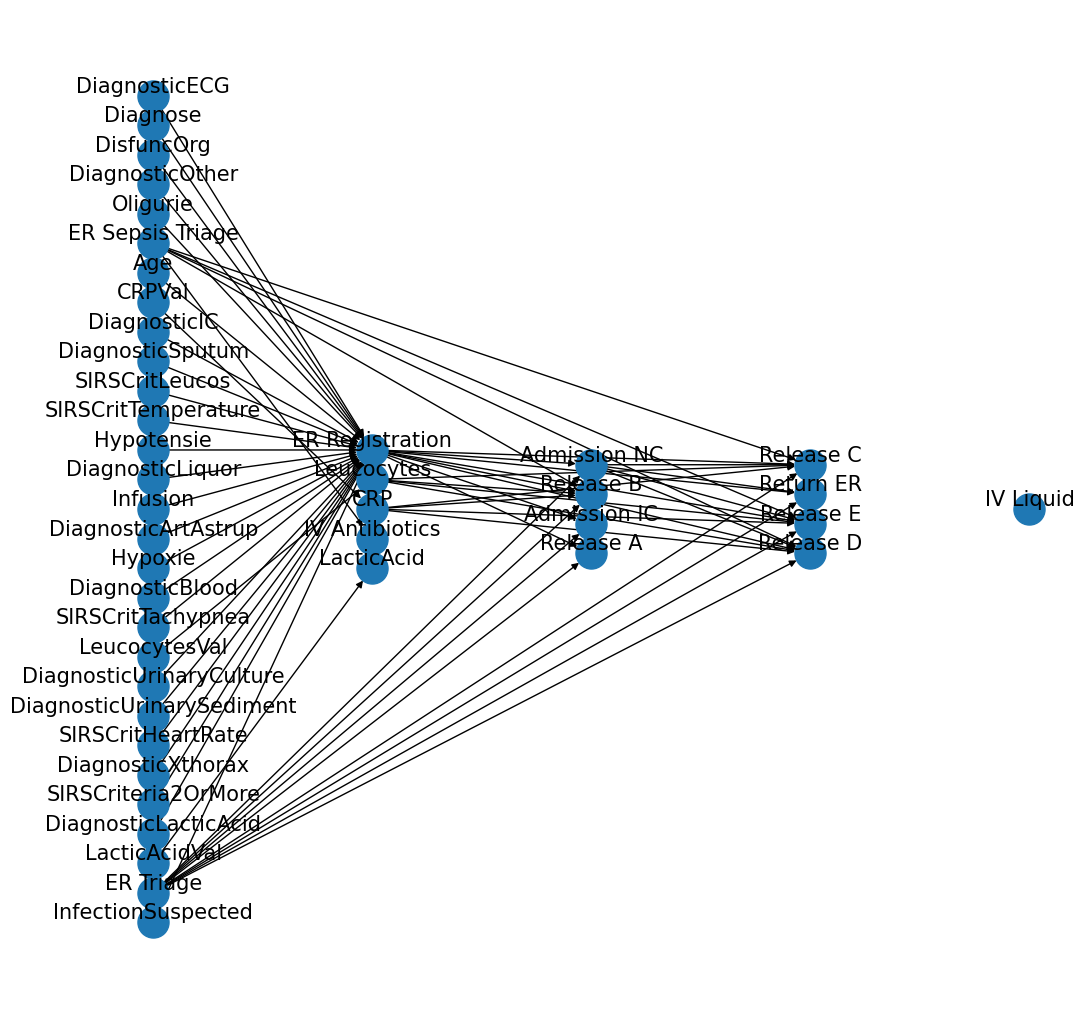

In [6]:
events_and_data = set(sepsis['concept:name'].unique())
data_filler_adj_matrix = {}
i = len(events)
for e,a in domain_knowledge.items():
    ks = set()
    for k,v in a.items():
        if v!='ignore':
            events_and_data.add(k)
            i += 1
            ks.add(k)
    data_filler_adj_matrix[e] = ks
adj_matrix = np.array([[0 for i in range(len(events_and_data))] for j in range(len(events_and_data))])
idx_dict = {}
for i, e1 in enumerate(events_and_data):
    idx_dict[e1] = i
    for j, e2 in enumerate(events_and_data):
        if e1 in log_abs['precedenceFor'] and e2 in log_abs['precedenceFor'][e1]:
            adj_matrix[j][i] = 1

for e, ds in data_filler_adj_matrix.items():
    for d in ds:
        i = idx_dict[e]
        j = idx_dict[d]
        adj_matrix[j][i] = 1

labels = {i:l for i,l in enumerate(events_and_data)}
show_graph_with_labels(adj_matrix, labels)

In [7]:
events = set(sepsis['concept:name'].unique())
event_and_data_functions = {}
event_and_plot_info = {}
for event in events:
    res = extract_event_binomial(event,sepsis, unfolded=False)
    for etemp, (func, prob) in res.items():
        event_and_data_functions[etemp] = func
        event_and_plot_info[etemp] = prob
attribute_events = {}
attribute_data_type = {}
for event, attributes in domain_knowledge.items():
    for attr, data_type in attributes.items():
        if attr not in attribute_events.keys():
            attribute_events[attr] = [event]
            attribute_data_type[attr] = data_type
        else:
            attribute_events[attr].append(event)

for attr, data_type in attribute_data_type.items():
    if data_type == 'categorical':
        event_and_data_functions[attr], pdict = extract_categorical_data_attribute(attribute_events[attr],attr,sepsis,group_threshold=-1)
        event_and_plot_info[attr] = pdict
    elif data_type == 'numerical':
        event_and_data_functions[attr] = extract_numerical_data_attribute(attribute_events[attr],attr,sepsis)
    elif data_type == 'binomial':
        event_and_data_functions[attr], prob = extract_data_binomial(attribute_events[attr],attr,sepsis)
observational_data_list = []

n = sepsis['case:concept:name'].nunique()
for i, case_df in enumerate(sepsis.groupby('case:concept:name')):
    data_dict = case_to_data_entry(case_df[1],events,attribute_data_type)
    observational_data_list.append(data_dict)
    # print(f'[i] {i+1}/{n} cid: {case_df[0]}')
    # if i+1 == 10000:
    #     break
event_x_cols = {}
event_y_cols = {}

instant_effects = True

for event in events:
    precedence_events = set(log_abs['precedenceFor'][event])
    precedence_data_attributes = set()
    for precedence_event in precedence_events:
        if precedence_event in data_filler_adj_matrix:
            precedence_data_attributes = precedence_data_attributes.union(set(data_filler_adj_matrix[precedence_event]))
    if instant_effects and event in data_filler_adj_matrix:
        precedence_data_attributes = precedence_data_attributes.union(set(data_filler_adj_matrix[event]))
    precedence_events = precedence_events.union(precedence_data_attributes)
    event_x_cols[event] = precedence_events
    event_y_cols[event] = event

[i] Event IV Antibiotics prob of success: 0.78
[i] Event Admission NC prob of success: 0.76
[i] Event LacticAcid prob of success: 0.82
[i] Event Release B prob of success: 0.05
[i] Event Leucocytes prob of success: 0.96
[i] Event Release C prob of success: 0.02
[i] Event Admission IC prob of success: 0.10
[i] Event Release D prob of success: 0.02
[i] Event Release E prob of success: 0.01
[i] Event Release A prob of success: 0.64
[i] Event CRP prob of success: 0.96
[i] Event ER Triage prob of success: 1.00
[i] Event ER Sepsis Triage prob of success: 1.00
[i] Event IV Liquid prob of success: 0.72
[i] Event ER Registration prob of success: 1.00
[i] Event Return ER prob of success: 0.28
['ER Registration'] DiagnosticBlood
[i] Binomial data attribute DiagnosticBlood for ['ER Registration'] prob of success: 0.78
['ER Registration'] SIRSCritHeartRate
[i] Binomial data attribute SIRSCritHeartRate for ['ER Registration'] prob of success: 0.77
['ER Registration'] DiagnosticLiquor
[i] Binomial da

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 27.76it/s]


[i] For numerical data attribute: Age dist:powerlaw params:{'a': 4.32912637652024, 'loc': -16.37682318867556, 'scale': 106.37682318867557}
['ER Registration'] InfectionSuspected
[i] Binomial data attribute InfectionSuspected for ['ER Registration'] prob of success: 0.81
['ER Registration'] SIRSCritTemperature
[i] Binomial data attribute SIRSCritTemperature for ['ER Registration'] prob of success: 0.76
['ER Registration'] SIRSCriteria2OrMore
[i] Binomial data attribute SIRSCriteria2OrMore for ['ER Registration'] prob of success: 0.81
['ER Registration'] SIRSCritTachypnea
[i] Binomial data attribute SIRSCritTachypnea for ['ER Registration'] prob of success: 0.57
['ER Registration'] Oligurie
[i] Binomial data attribute Oligurie for ['ER Registration'] prob of success: 0.02
['ER Registration'] Hypoxie
[i] Binomial data attribute Hypoxie for ['ER Registration'] prob of success: 0.02
['ER Registration'] DiagnosticXthorax
[i] Binomial data attribute DiagnosticXthorax for ['ER Registration'] p

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 27.97it/s]


[i] For numerical data attribute: CRPVal dist:exponpow params:{'b': 0.8610170650841269, 'loc': 4.999999999999999, 'scale': 191.53608332562405}
LacticAcidVal ['LacticAcid']


Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 39.98it/s]


[i] For numerical data attribute: LacticAcidVal dist:lognorm params:{'s': 0.6207815855690757, 'loc': 0.06846413867899678, 'scale': 1.5323811822914006}
LeucocytesVal ['Leucocytes']


Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 25.75it/s]


[i] For numerical data attribute: LeucocytesVal dist:cauchy params:{'loc': 10.606725418126521, 'scale': 3.295504956772903}


In [8]:
observational_data = pd.DataFrame(observational_data_list,columns=list(event_and_data_functions.keys()))
observational_data = observational_data.fillna(0)
for attr, data_type in attribute_data_type.items():
    if data_type == 'categorical':
        onehot = pd.get_dummies(observational_data[attr],dummy_na=False,prefix=attr)
        observational_data = pd.concat([observational_data,onehot],axis=1)
        observational_data = observational_data.drop(attr,axis=1)
    elif data_type == 'numerical':
        # mean normalization
        #pass
        observational_data[attr] = (observational_data[attr]-observational_data[attr].mean())/observational_data[attr].std()

In [9]:
set(observational_data.columns)

{'Admission IC',
 'Admission NC',
 'Age',
 'CRP',
 'CRPVal',
 'Diagnose_0',
 'Diagnose_A',
 'Diagnose_AA',
 'Diagnose_AB',
 'Diagnose_AC',
 'Diagnose_AD',
 'Diagnose_AE',
 'Diagnose_B',
 'Diagnose_BA',
 'Diagnose_BB',
 'Diagnose_BC',
 'Diagnose_BD',
 'Diagnose_BE',
 'Diagnose_C',
 'Diagnose_CA',
 'Diagnose_CB',
 'Diagnose_CC',
 'Diagnose_CD',
 'Diagnose_CE',
 'Diagnose_D',
 'Diagnose_DA',
 'Diagnose_DB',
 'Diagnose_DC',
 'Diagnose_DD',
 'Diagnose_DE',
 'Diagnose_E',
 'Diagnose_EA',
 'Diagnose_EB',
 'Diagnose_EC',
 'Diagnose_ED',
 'Diagnose_EE',
 'Diagnose_F',
 'Diagnose_FA',
 'Diagnose_FB',
 'Diagnose_FC',
 'Diagnose_FD',
 'Diagnose_FE',
 'Diagnose_G',
 'Diagnose_GA',
 'Diagnose_GB',
 'Diagnose_GC',
 'Diagnose_GD',
 'Diagnose_GE',
 'Diagnose_H',
 'Diagnose_HA',
 'Diagnose_HB',
 'Diagnose_HC',
 'Diagnose_HD',
 'Diagnose_HE',
 'Diagnose_I',
 'Diagnose_IA',
 'Diagnose_IB',
 'Diagnose_IC',
 'Diagnose_ID',
 'Diagnose_IE',
 'Diagnose_J',
 'Diagnose_JA',
 'Diagnose_JB',
 'Diagnose_JC',
 'Diag

In [10]:
observational_data

,IV Antibiotics,Admission NC,LacticAcid,Release B,Leucocytes,Release C,Admission IC,Release D,Release E,Release A,...,Diagnose_Y,Diagnose_YA,Diagnose_YB,Diagnose_YC,Diagnose_YD,Diagnose_Z,Diagnose_ZA,Diagnose_ZB,Diagnose_ZC,Diagnose_ZD
0,1,1,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,1,1,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1046,1,1,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1047,1,1,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1048,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


possible targets:
- Return ER:
    - Admission NC
    - Release A
    - Admission IC
These 3 variables have a causal effect on Return ER

In [11]:
cols = ['Return ER','Admission IC','Release A','Admission NC']
# for i in range(len(cols)):
target_idx = 0
n_splits = 2
s = int(len(observational_data)/n_splits)
splits = [(i+1)*s for i in range(n_splits-1)]
data = [observational_data[:splits[0]][cols].to_numpy()]
for i in range(len(splits)-1):
    data += [observational_data[splits[i]:splits[i+1]][cols].to_numpy()]
data += [observational_data[splits[len(splits)-1]:][cols].to_numpy()]

noise = [np.random.normal(0,0.1,data[0].shape)]
data[0] = data[0] + noise[0]

for k in range(len(data)-1):
    noise += [np.random.normal(0,0.1,data[k+1].shape)]
    data[k+1] = data[k+1] + noise[k+1]

res = icp.fit(data,target=target_idx, precompute=True, verbose=True, color=False)
if res and res.estimate:
    print(f'[icp]  {[cols[k] for k in res.estimate]} causal precedence for "{cols[res.target]}"')

Tested sets and their p-values:
  set() accepted : 1
  {1} accepted : 1
  {2} accepted : 1
  {3} accepted : 1
  {1, 2} accepted : 1
  {1, 3} accepted : 0.84585294793211
  {2, 3} accepted : 1
  {1, 2, 3} accepted : 1
Estimated parental set: set()


In [12]:
observational_data.columns.get_loc('Return ER')

15

In [13]:
import icpy

In [20]:
cols = list(observational_data.columns)
c_no_diag = []
for c in cols:
    if not c.startswith('Diagnose'):
        c_no_diag.append(c)
cols = c_no_diag
# for i in range(len(cols)):
target_idx = observational_data.columns.get_loc('Return ER')
x_cols = deepcopy(cols)
x_cols.remove(cols[target_idx])
data = [observational_data[observational_data['Return ER']==1][cols].to_numpy()]
data += [observational_data[observational_data['Return ER']==0][cols].to_numpy()]

noise = [np.random.normal(0,0.1,data[0].shape)]
# data[0] = data[0] + noise[0]
for k in range(len(data)-1):
    noise += [np.random.normal(0,0.1,data[k+1].shape)]
    # data[k+1] = data[k+1] + noise[k+1]

In [ ]:
res = icp.fit(data,target=target_idx, precompute=False, verbose=True, color=False)
if res and res.estimate:
    print(f'[icp]  {[cols[k] for k in res.estimate]} causal precedence for "{cols[res.target]}"')